<a href="https://colab.research.google.com/github/Sha271/JIE42903/blob/main/Stock_Market_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install yfinance

In [11]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# Define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# List of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Download the stock data
data = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker')

# Reset index to bring Date into the columns for the melt function
data = data.stack(level=0).reset_index()

# Melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date', 'Ticker'], var_name='Attribute', value_name='Value')

# Pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value', aggfunc='first')

# Reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

# Display the first few rows of the processed data
print(stock_data.head())

Attribute       Date       Ticker        Close         High          Low  \
0         2024-05-21  HDFCBANK.NS  1458.800049  1469.699951  1450.099976   
1         2024-05-21      INFY.NS  1398.136841  1408.421847  1392.531230   
2         2024-05-21  RELIANCE.NS  1436.125000  1441.824951  1425.599976   
3         2024-05-21       TCS.NS  3742.414795  3766.464967  3732.471560   
4         2024-05-22  HDFCBANK.NS  1459.199951  1465.599976  1448.150024   

Attribute         Open      Volume  
0          1450.099976  21884989.0  
1          1394.091028   6752663.0  
2          1425.599976  11176128.0  
3          3752.603178   1908117.0  
4          1457.849976  19998139.0  


<ipython-input-11-18064edb0b0b>:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index()


Columns in stock_data before plotting:
Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Attribute')


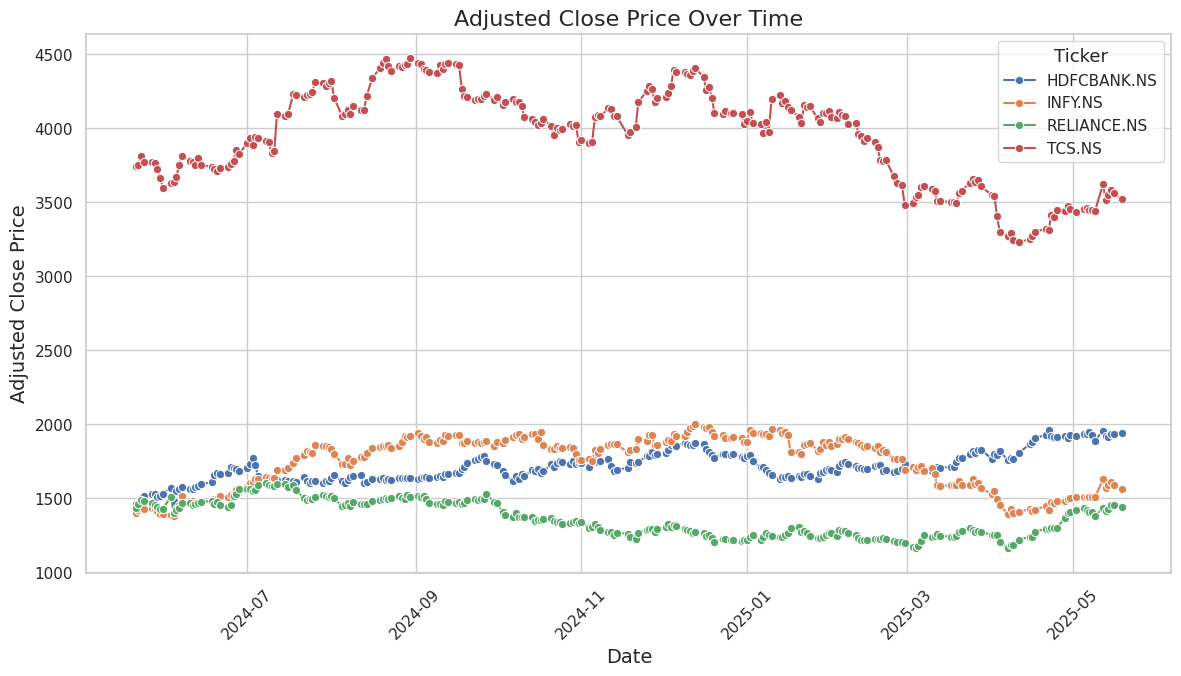

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported if not already

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Optional: Check column names before plotting
print("Columns in stock_data before plotting:")
print(stock_data.columns)


stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

# Check for the exact column name, it might be slightly different after processing
# If 'Adj Close' is not in the printed list of columns, you'll need to adjust the column name here.
# For example, if it's 'AdjClose' or 'Adj_Close', use that instead.
# sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker',
# marker='o')
sns.lineplot(data=stock_data, x='Date', y='Close', hue='Ticker', marker='o')


plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

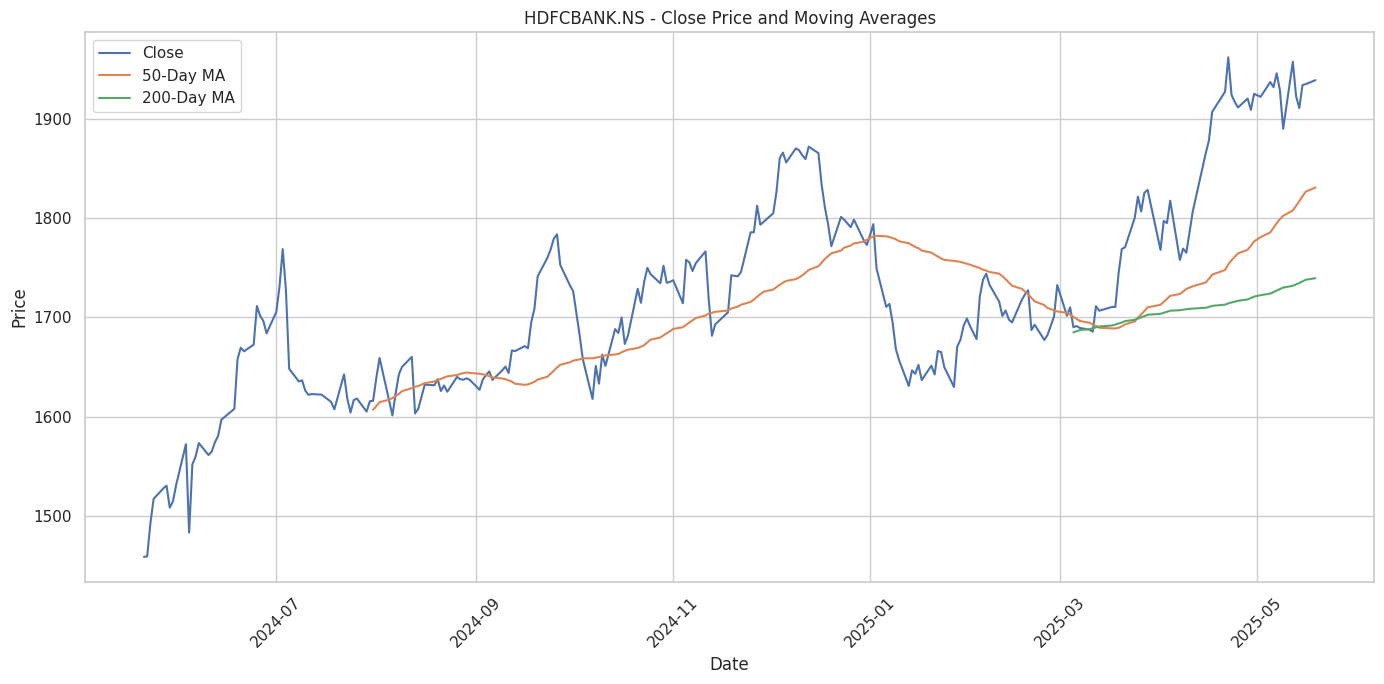

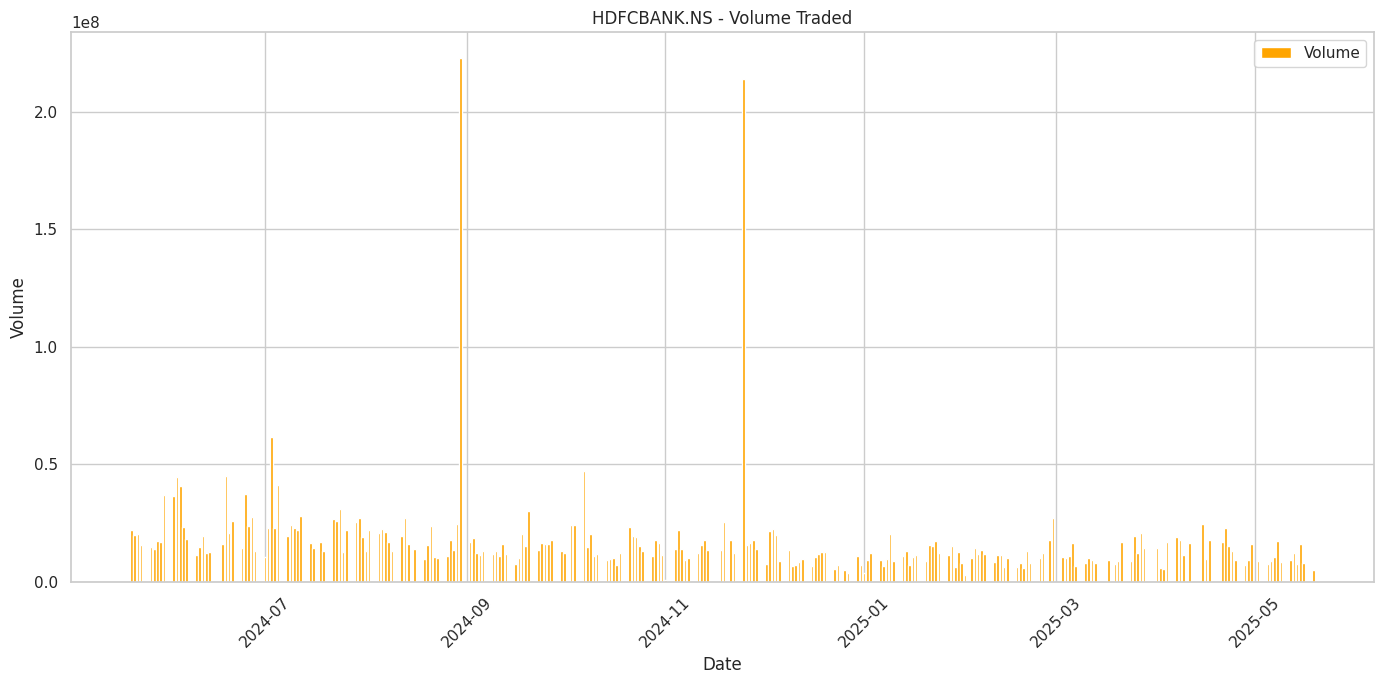

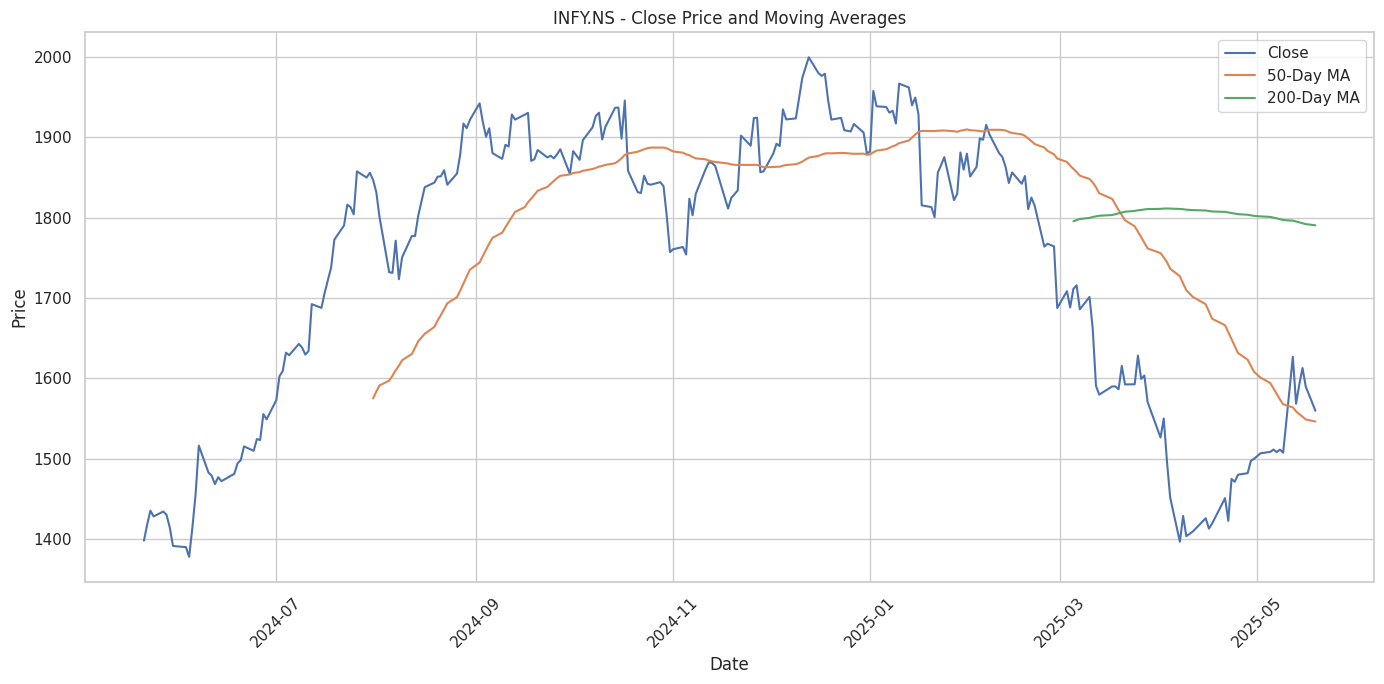

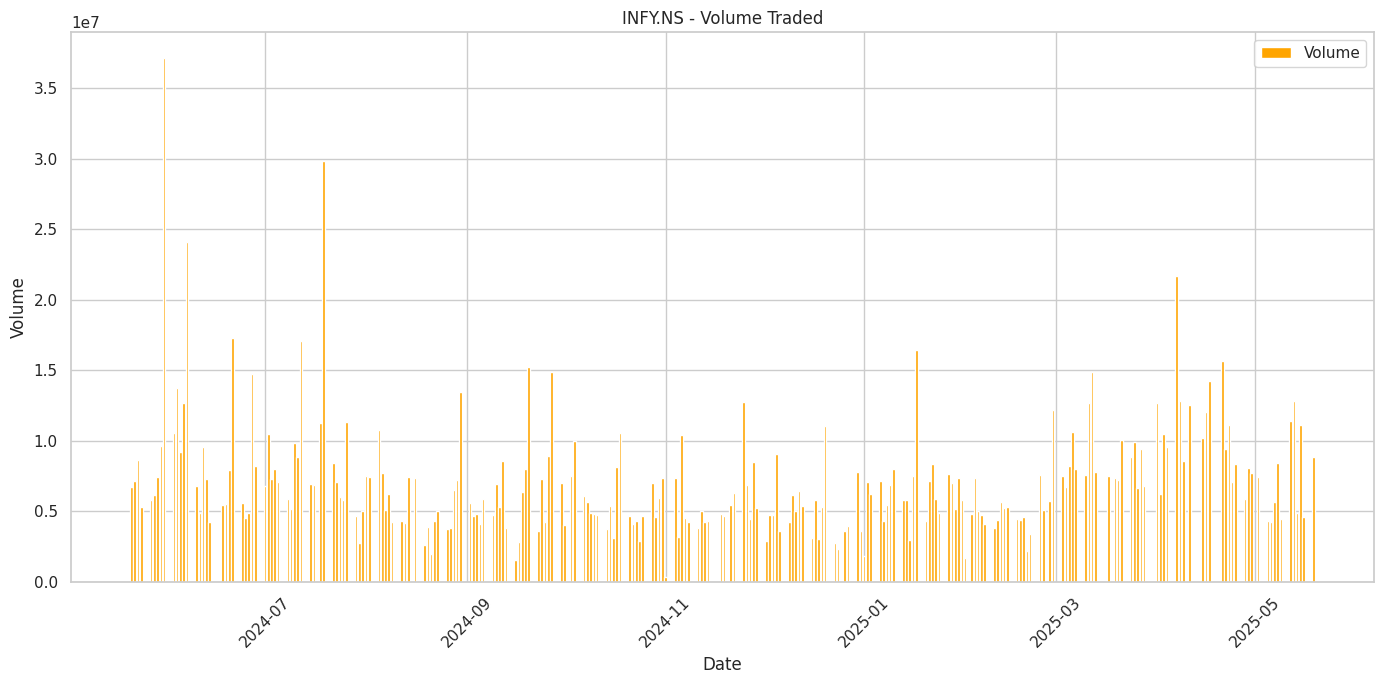

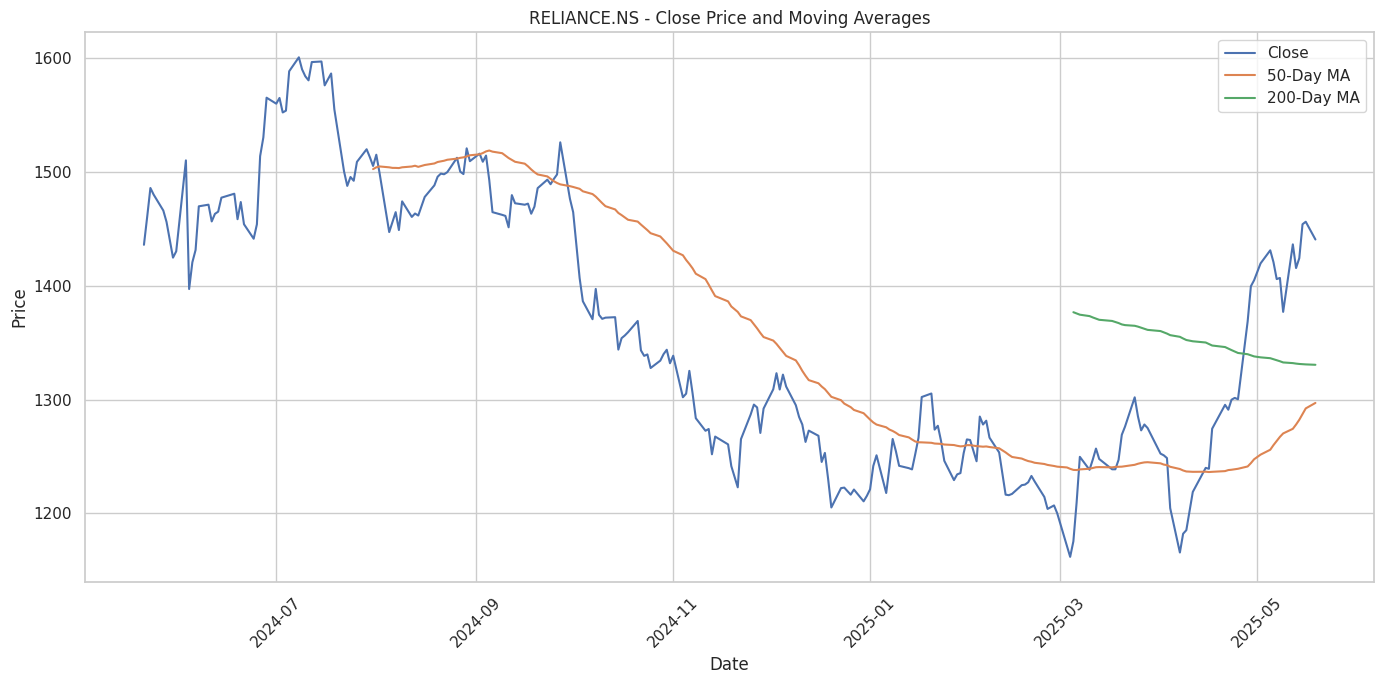

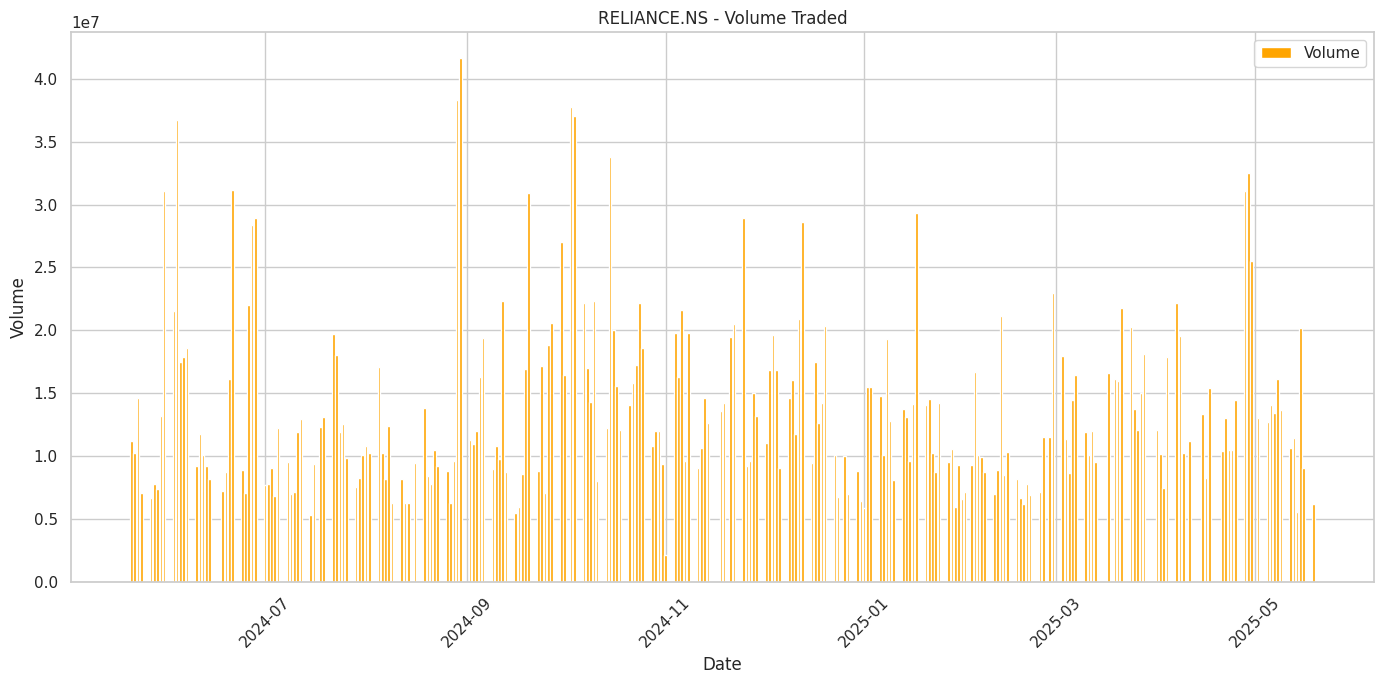

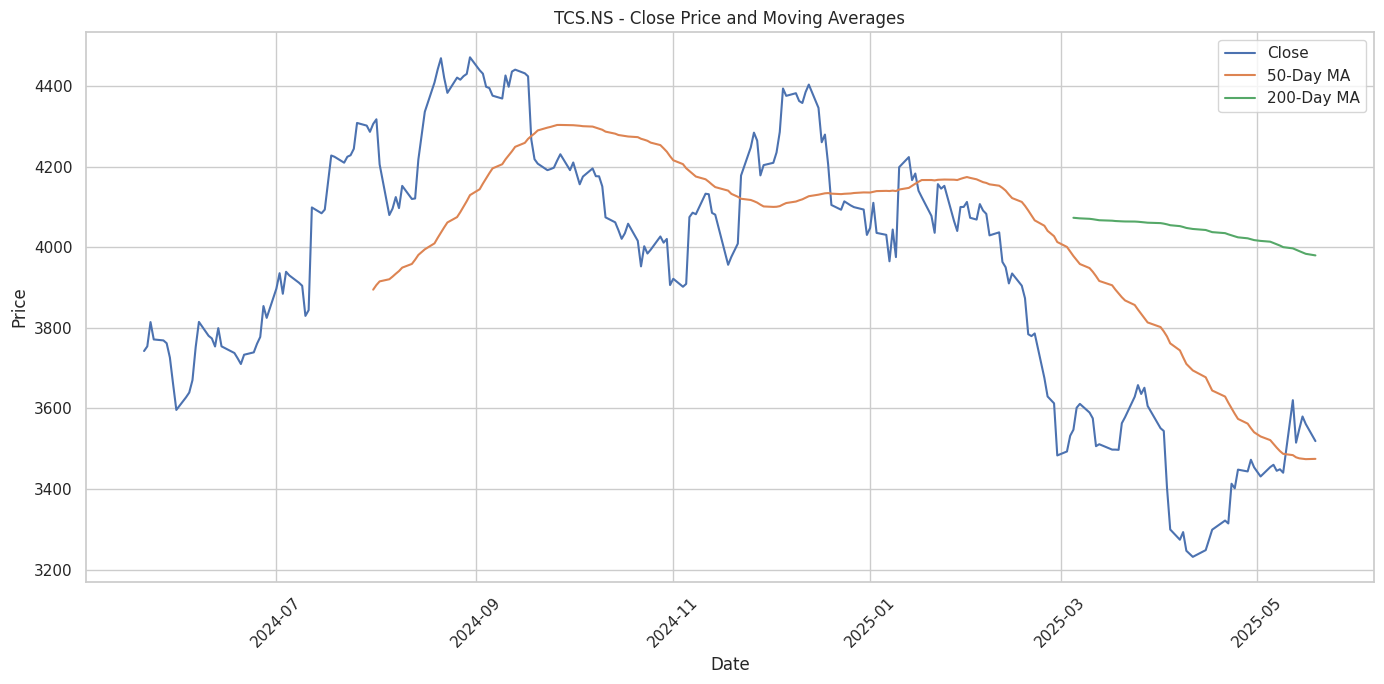

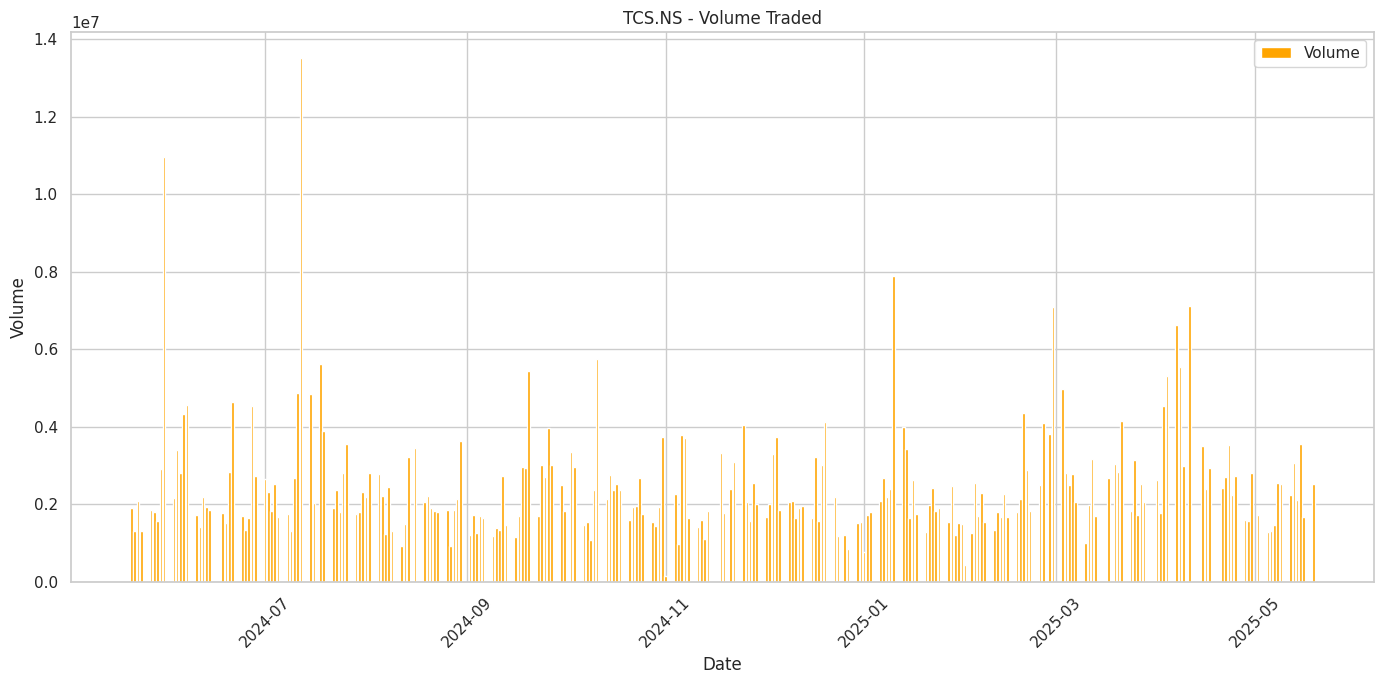

In [16]:
short_window = 50
long_window = 200

# Remove this line as the index is set in the previous cell
# stock_data.set_index('Date', inplace=True)

unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    # Ensure data is sorted by Date for correct rolling calculation
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy().sort_index()
    ticker_data['50_MA'] = ticker_data['Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Close'].rolling(window=long_window).mean()

    # Plot Close Price and Moving Averages
    plt.figure(figsize=(14, 7))
    # Use the index (Date) for plotting
    plt.plot(ticker_data.index, ticker_data['Close'], label='Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Close Price and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Volume
    plt.figure(figsize=(14, 7))
    # Use the index (Date) for plotting
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

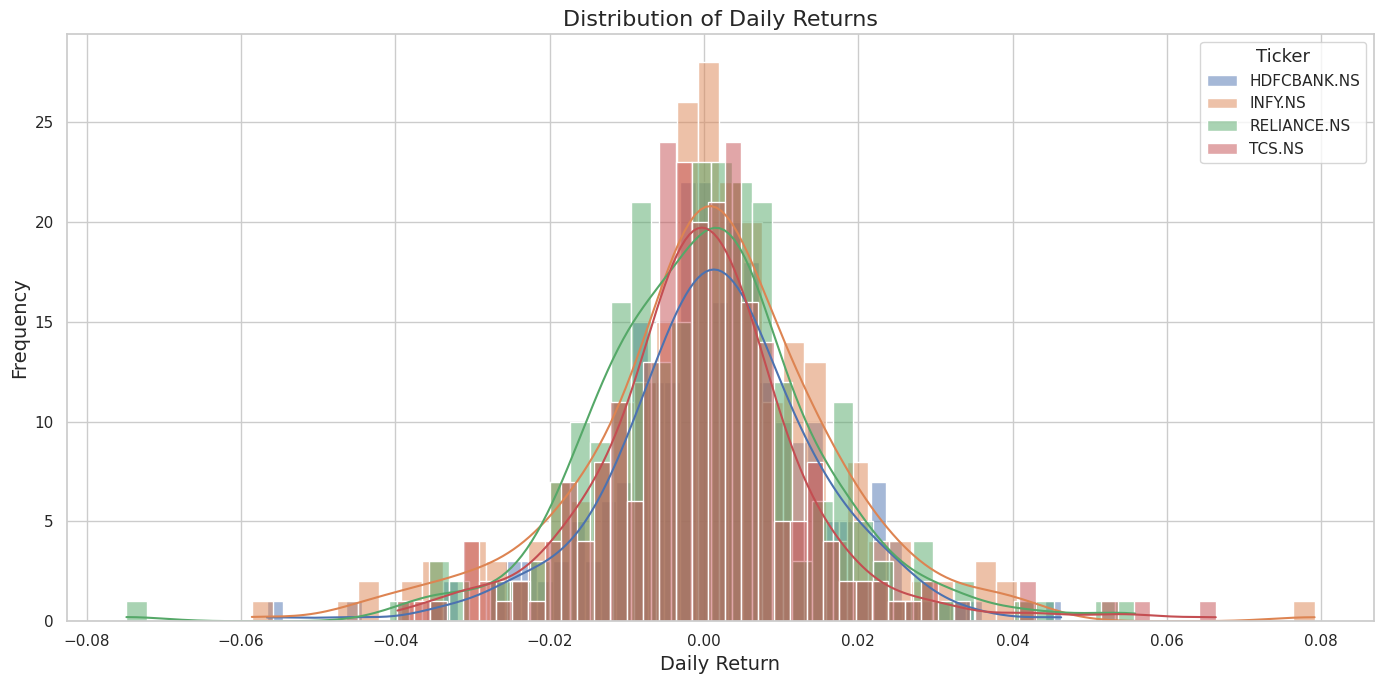

In [18]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Close'].pct_change() # Changed 'Adj Close' to 'Close'

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

# Ensure unique_tickers is defined (it was defined in a previous cell but good to be explicit if running this cell independently)
if 'unique_tickers' not in locals():
    unique_tickers = stock_data['Ticker'].unique()


for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

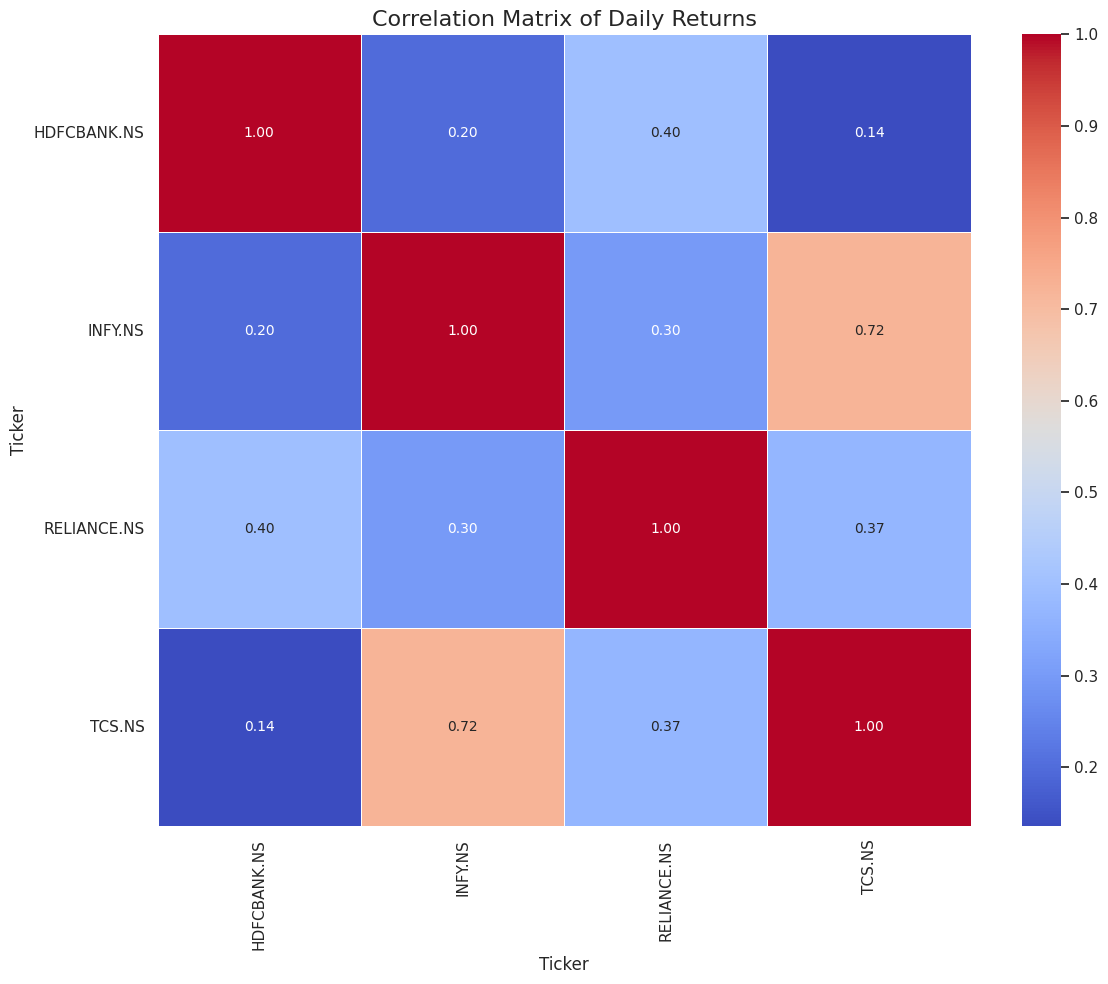

In [19]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.313950,0.211991
INFY.NS,0.146062,0.261189
RELIANCE.NS,0.031881,0.239304
TCS.NS,-0.038956,0.220984


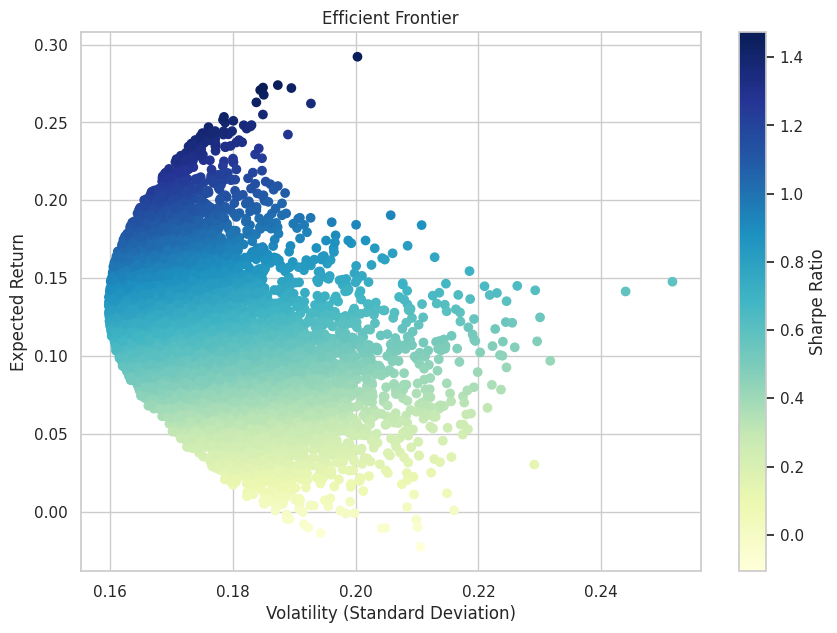

In [21]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [22]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(np.float64(0.2724257441135397),
 np.float64(0.18493740565692002),
 np.float64(1.4730699997972316))

In [23]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.193656
1,INFY.NS,0.373898
2,RELIANCE.NS,0.181925
3,TCS.NS,0.250521
